In [29]:
import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 2s 0us/step


In [3]:
test_images = test_images.astype('float32')
train_images = train_images.astype('float32')
test_images = test_images / 255
train_images = train_images / 255

num_classes = 10

In [8]:
def residual_block(x, filters, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

In [9]:
# Define ResNet-18
def resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

In [6]:
model = resnet18(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 16, 16, 64)           9408      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 16, 16, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 16, 16, 64)           0         ['batch_normalization[0][0

In [18]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_images, test_images = train_images.astype('float32') / 255, test_images.astype('float32') / 255

x_train, x_valid, y_train, y_valid = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(64)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(64)


In [25]:
model = resnet18(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
earlyStopping = callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='min')
mcp_save = callbacks.ModelCheckpoint('.model_cifar10.keras', save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')


In [27]:
# Train the model
history_resnet = model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/10
625/625 [==============================] - 85s 129ms/step - loss: 1.5012 - accuracy: 0.4682 - val_loss: 1.5505 - val_accuracy: 0.4461 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - 79s 127ms/step - loss: 1.0913 - accuracy: 0.6172 - val_loss: 2.1551 - val_accuracy: 0.3742 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - 79s 127ms/step - loss: 0.8922 - accuracy: 0.6883 - val_loss: 1.4335 - val_accuracy: 0.5522 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - 79s 126ms/step - loss: 0.7580 - accuracy: 0.7350 - val_loss: 1.5270 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 5/10
625/625 [==============================] - 80s 127ms/step - loss: 0.6621 - accuracy: 0.7684 - val_loss: 1.2005 - val_accuracy: 0.6254 - lr: 0.0010
Epoch 6/10
625/625 [==============================] - 80s 128ms/step - loss: 0.5558 - accuracy: 0.8053 - val_loss: 1.0171 - val_accuracy: 0.6784 - lr: 0.0010
Epoch 7/10
625/625 [==============================] 

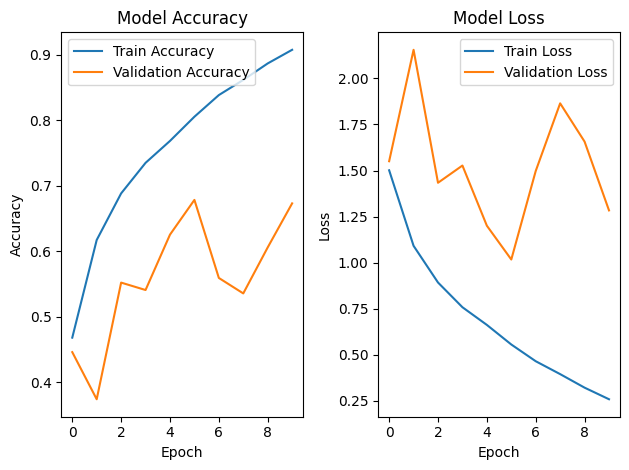

In [30]:
# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [31]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

def create_fine_tuned_mobilenetv2(input_shape=(32, 32, 3), num_classes=10):
    # Load pre-trained MobileNetV2
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Fine-tuned MobileNetV2 model
mobilenet_model = create_fine_tuned_mobilenetv2(input_shape=(32, 32, 3), num_classes=10)
mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [32]:
history_mobilenet = mobilenet_model.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)


Epoch 1/10
625/625 [==============================] - 23s 32ms/step - loss: 2.1046 - accuracy: 0.2436 - val_loss: 1.9634 - val_accuracy: 0.2930 - lr: 3.0000e-04
Epoch 2/10
625/625 [==============================] - 19s 30ms/step - loss: 1.9509 - accuracy: 0.2937 - val_loss: 1.9078 - val_accuracy: 0.3077 - lr: 3.0000e-04
Epoch 3/10
625/625 [==============================] - 19s 30ms/step - loss: 1.9096 - accuracy: 0.3092 - val_loss: 1.8852 - val_accuracy: 0.3149 - lr: 3.0000e-04
Epoch 4/10
625/625 [==============================] - 19s 31ms/step - loss: 1.8886 - accuracy: 0.3151 - val_loss: 1.8708 - val_accuracy: 0.3185 - lr: 3.0000e-04
Epoch 5/10
625/625 [==============================] - 19s 30ms/step - loss: 1.8720 - accuracy: 0.3219 - val_loss: 1.8597 - val_accuracy: 0.3240 - lr: 3.0000e-04
Epoch 6/10
625/625 [==============================] - 19s 30ms/step - loss: 1.8591 - accuracy: 0.3276 - val_loss: 1.8517 - val_accuracy: 0.3244 - lr: 3.0000e-04
Epoch 7/10
625/625 [==============

In [ ]:
# Unfreeze the top layers of the base model for fine-tuning
for layer in mobilenet_model.layers[0].layers[-20:]:
    layer.trainable = True

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics=['accuracy'])

# Re-Train the model
history_fine_tune = mobilenet_model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)


Epoch 1/20
625/625 [==============================] - 24s 35ms/step - loss: 1.4463 - accuracy: 0.4823 - val_loss: 1.5886 - val_accuracy: 0.4398 - lr: 1.0000e-04
Epoch 2/20
625/625 [==============================] - 20s 32ms/step - loss: 1.4048 - accuracy: 0.4994 - val_loss: 1.5756 - val_accuracy: 0.4448 - lr: 1.0000e-04
Epoch 3/20
625/625 [==============================] - 20s 32ms/step - loss: 1.3682 - accuracy: 0.5120 - val_loss: 1.5654 - val_accuracy: 0.4504 - lr: 1.0000e-04
Epoch 4/20
625/625 [==============================] - 20s 32ms/step - loss: 1.3323 - accuracy: 0.5237 - val_loss: 1.5594 - val_accuracy: 0.4532 - lr: 1.0000e-04
Epoch 5/20
625/625 [==============================] - 20s 32ms/step - loss: 1.2963 - accuracy: 0.5376 - val_loss: 1.5545 - val_accuracy: 0.4547 - lr: 1.0000e-04
Epoch 6/20
625/625 [==============================] - 20s 32ms/step - loss: 1.2641 - accuracy: 0.5494 - val_loss: 1.5499 - val_accuracy: 0.4575 - lr: 1.0000e-04
Epoch 7/20
625/625 [==============

In [34]:
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(test_images, test_labels, verbose=2)
print(f"MobileNetV2 Test Accuracy after Fine-Tuning: {test_acc_mobilenet:.4f}")


313/313 - 5s - loss: 1.6054 - accuracy: 0.4417 - 5s/epoch - 17ms/step
MobileNetV2 Test Accuracy after Fine-Tuning: 0.4417


In [58]:
test_loss_resnet, test_acc_resnet = model.evaluate(test_images, test_labels, verbose=2)
print(f"Resnet 18 Test Accuracy: {test_acc_resnet:.4f}")

313/313 - 5s - loss: 1.6349 - accuracy: 0.6378 - 5s/epoch - 16ms/step
Resnet 18 Test Accuracy: 0.6378


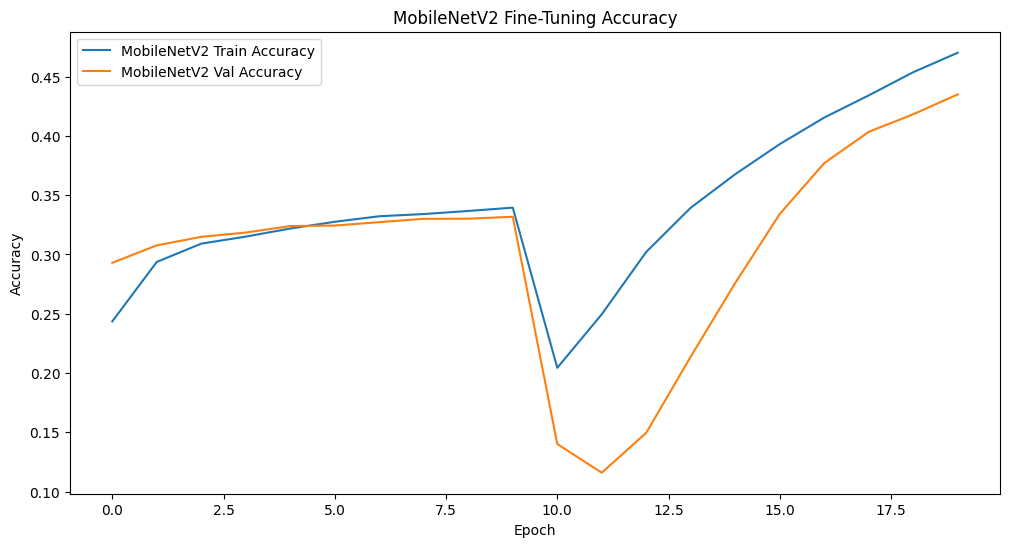

In [36]:

# Training & validation accuracy for the fine-tuning phase
plt.figure(figsize=(12, 6))

# MobileNetV2 fine-tuning accuracy
plt.plot(history_mobilenet.history['accuracy'] + history_fine_tune.history['accuracy'], label='MobileNetV2 Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='MobileNetV2 Val Accuracy')
plt.title('MobileNetV2 Fine-Tuning Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [50]:
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

# Define various optimizers
optimizers = {
    "SGD": SGD(learning_rate=0.01, momentum=0.9),
    "Adam": Adam(learning_rate=0.0001),
    "RMSprop": RMSprop(learning_rate=0.001)
}

# Choose an optimizer for the experiment
chosen_optimizer = optimizers["SGD"]

model_SDG = resnet18(input_shape=(32, 32, 3), num_classes=10)



In [51]:
model_SDG.compile(optimizer=chosen_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [52]:
history_resnet_SDG = model_SDG.fit(
    train_dataset,
    epochs=10,
    validation_data=valid_dataset,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/10
625/625 [==============================] - 78s 122ms/step - loss: 1.8288 - accuracy: 0.4011 - val_loss: 1.7154 - val_accuracy: 0.3751 - lr: 0.0100
Epoch 2/10
625/625 [==============================] - 75s 121ms/step - loss: 1.4191 - accuracy: 0.5162 - val_loss: 1.2607 - val_accuracy: 0.5574 - lr: 0.0100
Epoch 3/10
625/625 [==============================] - 76s 121ms/step - loss: 1.2032 - accuracy: 0.5925 - val_loss: 1.3078 - val_accuracy: 0.5477 - lr: 0.0100
Epoch 4/10
625/625 [==============================] - 75s 120ms/step - loss: 1.0430 - accuracy: 0.6470 - val_loss: 1.2442 - val_accuracy: 0.5687 - lr: 0.0100
Epoch 5/10
625/625 [==============================] - 75s 121ms/step - loss: 0.8672 - accuracy: 0.7010 - val_loss: 1.3361 - val_accuracy: 0.5689 - lr: 0.0100
Epoch 6/10
625/625 [==============================] - 75s 121ms/step - loss: 0.7293 - accuracy: 0.7487 - val_loss: 1.4323 - val_accuracy: 0.5694 - lr: 0.0100
Epoch 7/10
625/625 [==============================] 

In [57]:
test_loss_resnet, test_acc_resnet = model_SDG.evaluate(test_images, test_labels, verbose=2)
print(f"Resnet 18 Test Accuracy: {test_acc_resnet:.4f}")

313/313 - 5s - loss: 1.7970 - accuracy: 0.5674 - 5s/epoch - 16ms/step
Resnet 18 Test Accuracy after Fine-Tuning: 0.5674


In [69]:
chosen_optimizer = optimizers["RMSprop"]


In [70]:
model_RMSprop = resnet18(input_shape=(32, 32, 3), num_classes=10)

model_RMSprop.compile(optimizer=chosen_optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [72]:
history_resnet_Adam = model_RMSprop.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
)

Epoch 1/20
625/625 [==============================] - 82s 126ms/step - loss: 1.5555 - accuracy: 0.4631 - val_loss: 1.8311 - val_accuracy: 0.4102 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 78s 125ms/step - loss: 1.0801 - accuracy: 0.6240 - val_loss: 1.5907 - val_accuracy: 0.4953 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 78s 125ms/step - loss: 0.8754 - accuracy: 0.6977 - val_loss: 1.2118 - val_accuracy: 0.5910 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 78s 125ms/step - loss: 0.7265 - accuracy: 0.7498 - val_loss: 1.2148 - val_accuracy: 0.6119 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 78s 125ms/step - loss: 0.5917 - accuracy: 0.7974 - val_loss: 1.4497 - val_accuracy: 0.5948 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 78s 125ms/step - loss: 0.4746 - accuracy: 0.8362 - val_loss: 1.4621 - val_accuracy: 0.6122 - lr: 0.0010
Epoch 7/20
625/625 [==============================] 

In [59]:
test_loss_resnet, test_acc_resnet = model_Adam.evaluate(test_images, test_labels, verbose=2)
print(f"Resnet 18 Test Accuracy: {test_acc_resnet:.4f}")

313/313 - 5s - loss: 1.8069 - accuracy: 0.6059 - 5s/epoch - 16ms/step
Resnet 18 Test Accuracy: 0.6059
